<a href="https://colab.research.google.com/github/ksaykili/LIN340-Project/blob/main/LIN340_Scratch_replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
def extract_TACEM_phrases(text):
    doc = nlp(text)

    tacem_phrases = {
        'thoughts': [],
        'actions': [],
        'contexts': [],
        'emotions': [],
        'motivations': []
    }

    for token in doc:
        if token.pos_ != "VERB":
            continue

        phrase_tokens = list(token.subtree)
        phrase = " ".join([w.text for w in phrase_tokens if not w.is_punct and w.text.strip() != ""])

        lemma = token.lemma_
        has_adj = any(w.dep_ in ("acomp", "attr", "xcomp") and w.pos_ == "ADJ" for w in token.children)
        has_prep = any(w.dep_ == "prep" for w in token.children)
        has_nsubj = any(w.dep_ == "nsubj" for w in token.children)

        if lemma in ("feel", "be") and has_adj:
            tacem_phrases['emotions'].append(phrase)
        elif lemma in ("think", "know", "believe", "understand", "wonder", "doubt"):
            tacem_phrases['thoughts'].append(phrase)
        elif lemma in ("want", "need", "hope", "wish", "try", "plan", "desire"):
            tacem_phrases['motivations'].append(phrase)
        elif lemma in ("sleep", "eat", "cut", "harm", "cry", "stay", "leave", "hurt", "stop", "skip", "shower") and has_nsubj:
            tacem_phrases['actions'].append(phrase)
        elif has_prep:
            tacem_phrases['contexts'].append(phrase)

    # NEW: Catch standalone prepositional context phrases
    for token in doc:
        if token.dep_ == "prep" and token.head.pos_ != "VERB":
            context_phrase = " ".join([w.text for w in token.subtree if not w.is_punct])
            if context_phrase not in tacem_phrases["contexts"]:
                tacem_phrases["contexts"].append(context_phrase)

    return tacem_phrases


In [ ]:
text = """
I feel hopeless. I think no one will ever help. I want to disappear.
After the breakup, I stopped eating and sleep all day. I need someone.
"""

results = extract_TACEM_phrases(text)
for k in results:
    print(f"{k.upper()}: {results[k]}")


THOUGHTS: ['I think no one will ever help']
ACTIONS: ['After the breakup I stopped eating and sleep all day']
CONTEXTS: []
EMOTIONS: ['I feel hopeless']
MOTIVATIONS: ['I want to disappear', 'I need someone']


In [ ]:
import pandas as pd

df = pd.read_csv("suicide-mental-health.csv")
df.head()


,text,label
0,I recently went through a breakup and she said...,depression
1,"I do not know how to navigate these feelings, ...",depression
2,"So I have been with my bf for 5 months , and h...",depression
3,I am so exhausted of this. Just when I think I...,SuicideWatch
4,I have been severly bullied since i was 5 till...,depression


In [ ]:
# Make sure your TACEM function is defined above
# Apply TACEM to each post
df["tacem_output"] = df["text"].apply(extract_TACEM_phrases)


In [ ]:
df.head()
df.loc[5]['text']
df.loc[5]['label']
df.loc[5]['tacem_output']

{'thoughts': [],
 'actions': [],
 'contexts': ['succeeding in life without even trying like the relationship part without even wanting one',
  'to put them through this',
  'I am playing my life on hard mode while everyone is on easy mode',
  'with some good friends',
  'with bullying',
  'like',
  'by myself',
  'of my friends',
  'on easy mode'],
 'emotions': ['and I just feel fucking jealous',
  'I feel disgusted by myself that I am jealous of my friends and I just want to end it all'],
 'motivations': ['even trying like the relationship part without even wanting one',
  'even wanting one',
  'I want',
  'I just want to end it',
  'and I do not want to put them through this']}

In [ ]:
df.head()
df.loc[6]['text']
df.loc[6]['label']
df.loc[6]['tacem_output']

{'thoughts': ['she knows that I hate', 'where I can think to myself'],
 'actions': [],
 'contexts': ['me go to a camp she knows that I hate',
  'at midnight where I can think to myself',
  'from my dog'],
 'emotions': [],
 'motivations': ['I do not want to call CPS because she does small things but they build up and I do not want to be taken away from my dog',
  'and I do not want to be taken away from my dog']}

In [ ]:
df['tacem_output'] = df['text'].apply(extract_TACEM_phrases)

In [ ]:
def tacem_counts(tacem_dict):
    return {k + '_count': len(v) for k, v in tacem_dict.items()}

In [ ]:
tacem_counts_df = df["tacem_output"].apply(tacem_counts).apply(pd.Series)
df = pd.concat([df, tacem_counts_df], axis=1)

In [ ]:
df.head()

,text,label,tacem_output,thoughts_count,actions_count,contexts_count,emotions_count,motivations_count
0,I recently went through a breakup and she said...,depression,{'thoughts': ['but I do not know what to do he...,2,5,3,0,6
1,"I do not know how to navigate these feelings, ...",depression,{'thoughts': ['I do not know how to navigate t...,3,1,21,1,2
2,"So I have been with my bf for 5 months , and h...",depression,{'thoughts': ['etcI know I am not the problem ...,1,0,7,0,1
3,I am so exhausted of this. Just when I think I...,SuicideWatch,{'thoughts': ['Just when I think I can finally...,7,3,10,1,3
4,I have been severly bullied since i was 5 till...,depression,"{'thoughts': [], 'actions': [], 'contexts': ['...",0,0,13,0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Select only TACEM count columns
X = df[['thoughts_count', 'actions_count', 'contexts_count', 'emotions_count', 'motivations_count']]
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

SuicideWatch       0.58      0.62      0.60      2029
  depression       0.59      0.54      0.57      2044

    accuracy                           0.58      4073
   macro avg       0.58      0.58      0.58      4073
weighted avg       0.58      0.58      0.58      4073



In [ ]:
# Create one column per TACEM quadrant with concatenated phrases
for quadrant in ['thoughts', 'actions', 'contexts', 'emotions', 'motivations']:
    df[quadrant] = df['tacem_output'].apply(lambda d: " ".join(d.get(quadrant, [])) if isinstance(d, dict) else "")

In [ ]:
df.head()

,text,label,tacem_output,thoughts_count,actions_count,contexts_count,emotions_count,motivations_count,thoughts,actions,contexts,emotions,motivations
0,I recently went through a breakup and she said...,depression,{'thoughts': ['but I do not know what to do he...,2,5,3,0,6,but I do not know what to do here so I do not ...,it always hurts so all this pain can stop it h...,I recently went through a breakup and she said...,,she still wants to be friends I can try doing ...
1,"I do not know how to navigate these feelings, ...",depression,{'thoughts': ['I do not know how to navigate t...,3,1,21,1,2,I do not know how to navigate these feelings n...,I stop and when look around,how I can go on from being so pleasantly fine ...,and I feel so ashamed for how serious my negat...,that I want I just wanted to say this out loud...
2,"So I have been with my bf for 5 months , and h...",depression,{'thoughts': ['etcI know I am not the problem ...,1,0,7,0,1,etcI know I am not the problem I am aware of that,,To this week nothing particular happened but i...,,He does not ask me to sleep together do things...
3,I am so exhausted of this. Just when I think I...,SuicideWatch,{'thoughts': ['Just when I think I can finally...,7,3,10,1,3,Just when I think I can finally rest just when...,This month alone we found out my mum could be ...,another hurdle comes flying at me to A&amp;E w...,I feel sick,that they wanted a divorce like life is trying...
4,I have been severly bullied since i was 5 till...,depression,"{'thoughts': [], 'actions': [], 'contexts': ['...",0,0,13,0,1,,,I have been severly bullied since i was 5 till...,,but i just do not want to deal with this const...


In [ ]:
print("Suicide MOTIVATIONS:\n", df[df['label'] == 'SuicideWatch']['motivations'].dropna().head(5).tolist())
print("Depression MOTIVATIONS:\n", df[df['label'] == 'depression']['motivations'].dropna().head(5).tolist())

Suicide MOTIVATIONS:
 ['that they wanted a divorce like life is trying to get me to kill myself Life is really fucking trying me', 'even trying like the relationship part without even wanting one even wanting one I want I just want to end it and I do not want to put them through this', 'I try and try and try try and try try', 'foodAnd other things I will be judged for and for having weird views because maybe I am delusional I want to go to jail', 'I just want to get back in my routine but idk shit sucks']
Depression MOTIVATIONS:
 ['she still wants to be friends I can try doing that I just want to lose feelings so all this pain can stop it hurts so much I do not want to hurt her because she said she does not want to never speak to me again she does not want to never speak to me again I wish we never met it would be much less painful', 'that I want I just wanted to say this out loud or whatever', 'He does not ask me to sleep together do things and etcI know I am not the problem I am awar

In [ ]:
def extract_intent_phrases(text):
    if not isinstance(text, str) or not text.strip():
        return []

    doc = nlp(text)
    phrases = []

    # Intent-driving verbs (expandable set)
    lead_verbs = {
        'want', 'need', 'wish', 'desire', 'hope', 'crave', 'long', 'yearn',
        'try', 'attempt', 'struggle', 'fight', 'manage', 'work', 'endeavor', 'push',
        'plan', 'decide', 'prepare', 'expect', 'aim', 'choose', 'resolve', 'intend',
        'refuse', 'avoid', 'resist', 'deny', 'hesitate', 'fear', 'dread', 'fail',
        'have', 'must', 'should', 'ought', 'forced', 'obligated',
        'ask', 'allow', 'let', 'permit', 'beg', 'plead',
        'give', 'surrender', 'submit', 'stop', 'quit',
        'cut', 'hurt', 'harm', 'punish', 'end', 'escape', 'kill'
    }

    for token in doc:
        # Check for intent-driving verb
        if token.lemma_ in lead_verbs and token.pos_ == "VERB":
            negation = "not " if any(child.dep_ == "neg" for child in token.children) else ""

            # Look for second verb (the intent) connected via xcomp
            for child in token.children:
                if child.dep_ == "xcomp" and child.pos_ == "VERB":
                    phrase = f"{negation}{token.text} to {child.lemma_}"
                    phrases.append(phrase)

    return phrases


In [ ]:
for quadrant in ['thoughts', 'motivations', 'emotions', 'contexts', 'actions']:
    df[f'{quadrant}_intents'] = df[quadrant].apply(extract_intent_phrases)

In [ ]:
df.head()

,text,label,tacem_output,thoughts_count,actions_count,contexts_count,emotions_count,motivations_count,thoughts,actions,contexts,emotions,motivations,thoughts_intents,motivations_intents,emotions_intents,contexts_intents,actions_intents
0,I recently went through a breakup and she said...,depression,{'thoughts': ['but I do not know what to do he...,2,5,3,0,6,but I do not know what to do here so I do not ...,it always hurts so all this pain can stop it h...,I recently went through a breakup and she said...,,she still wants to be friends I can try doing ...,[],"[try to do, want to lose, not want to hurt, no...",[],[hurts to speak],[]
1,"I do not know how to navigate these feelings, ...",depression,{'thoughts': ['I do not know how to navigate t...,3,1,21,1,2,I do not know how to navigate these feelings n...,I stop and when look around,how I can go on from being so pleasantly fine ...,and I feel so ashamed for how serious my negat...,that I want I just wanted to say this out loud...,[wanted to say],[wanted to say],[],[],[]
2,"So I have been with my bf for 5 months , and h...",depression,{'thoughts': ['etcI know I am not the problem ...,1,0,7,0,1,etcI know I am not the problem I am aware of that,,To this week nothing particular happened but i...,,He does not ask me to sleep together do things...,[],"[not ask to sleep, wanted to ask]",[],[],[]
3,I am so exhausted of this. Just when I think I...,SuicideWatch,{'thoughts': ['Just when I think I can finally...,7,3,10,1,3,Just when I think I can finally rest just when...,This month alone we found out my mum could be ...,another hurdle comes flying at me to A&amp;E w...,I feel sick,that they wanted a divorce like life is trying...,[],[trying to get],[],[],[]
4,I have been severly bullied since i was 5 till...,depression,"{'thoughts': [], 'actions': [], 'contexts': ['...",0,0,13,0,1,,,I have been severly bullied since i was 5 till...,,but i just do not want to deal with this const...,[],[not want to deal],[],[not want to deal],[]


In [ ]:
import pandas as pd
df = pd.read_csv('suicide-mental-health.csv')
print(df.head())

                                                text         label
0  I recently went through a breakup and she said...    depression
1  I do not know how to navigate these feelings, ...    depression
2  So I have been with my bf for 5 months , and h...    depression
3  I am so exhausted of this. Just when I think I...  SuicideWatch
4  I have been severly bullied since i was 5 till...    depression


In [ ]:
# ML Approach Preprocessing: Create a cleaned version of text for traditional ML pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Download required NLTK data
nltk.download('stopwords')

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define the cleaning function
def clean_text_ml(text):
    text = str(text).lower()                          # 1. Lowercasing
    text = re.sub(r'\d+', '', text)                   # 2. Remove numbers
    text = re.sub(r'[^\w\s]', '', text)               # 3. Remove punctuation
    tokens = text.split()                             # 4. Tokenization
    tokens = [w for w in tokens if w not in stop_words]     # 5. Stopword removal
    tokens = [stemmer.stem(w) for w in tokens]              # 6. Stemming
    return " ".join(tokens)

# Apply and store in a new column
df['text_ml'] = df['text'].apply(clean_text_ml)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.iloc[10:20]

,text,label,text_ml
10,Been stuck in a loop of ruminating/ overthinki...,depression,stuck loop rumin overthink still cannot seem c...
11,Since I began seeing a therapist 5 months ago ...,depression,sinc began see therapist month ago realis thou...
12,Did your depression start after a time of seri...,depression,depress start time seriou stressanxieti may fe...
13,I am on zoloft and focalin and it is changed m...,SuicideWatch,zoloft focalin chang life past four year bette...
14,I am going to make this short because i hate t...,depression,go make short hate think long stori short get ...
15,"I have really bad feelings, but always when I ...",SuicideWatch,realli bad feel alway tri look someth relat fo...
16,Everyone in my schooling system thinks I am au...,SuicideWatch,everyon school system think autist realli fake...
17,I have been talking to someone who I really li...,depression,talk someon realli like great person realli cl...
18,"I have so many stressors in my life, all major...",SuicideWatch,mani stressor life major thing tear everi day ...
19,Imagine waking up only hanging on by a thread ...,SuicideWatch,imagin wake hang thread get call bank lost fra...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text_ml'])
y = df['label']
df.iloc[10:20]

,text,label,text_ml
10,Been stuck in a loop of ruminating/ overthinki...,depression,stuck loop rumin overthink still cannot seem c...
11,Since I began seeing a therapist 5 months ago ...,depression,sinc began see therapist month ago realis thou...
12,Did your depression start after a time of seri...,depression,depress start time seriou stressanxieti may fe...
13,I am on zoloft and focalin and it is changed m...,SuicideWatch,zoloft focalin chang life past four year bette...
14,I am going to make this short because i hate t...,depression,go make short hate think long stori short get ...
15,"I have really bad feelings, but always when I ...",SuicideWatch,realli bad feel alway tri look someth relat fo...
16,Everyone in my schooling system thinks I am au...,SuicideWatch,everyon school system think autist realli fake...
17,I have been talking to someone who I really li...,depression,talk someon realli like great person realli cl...
18,"I have so many stressors in my life, all major...",SuicideWatch,mani stressor life major thing tear everi day ...
19,Imagine waking up only hanging on by a thread ...,SuicideWatch,imagin wake hang thread get call bank lost fra...


In [ ]:
print(df['label'].unique())

['depression' 'SuicideWatch']


In [ ]:
df['label'] = df['label'].str.strip().str.lower()

# Step 2: Map to numeric labels
df['label'] = df['label'].map({'depression': 0, 'suicidewatch': 1})
df.iloc[10:20]

,text,label,text_ml
10,Been stuck in a loop of ruminating/ overthinki...,0,stuck loop rumin overthink still cannot seem c...
11,Since I began seeing a therapist 5 months ago ...,0,sinc began see therapist month ago realis thou...
12,Did your depression start after a time of seri...,0,depress start time seriou stressanxieti may fe...
13,I am on zoloft and focalin and it is changed m...,1,zoloft focalin chang life past four year bette...
14,I am going to make this short because i hate t...,0,go make short hate think long stori short get ...
15,"I have really bad feelings, but always when I ...",1,realli bad feel alway tri look someth relat fo...
16,Everyone in my schooling system thinks I am au...,1,everyon school system think autist realli fake...
17,I have been talking to someone who I really li...,0,talk someon realli like great person realli cl...
18,"I have so many stressors in my life, all major...",1,mani stressor life major thing tear everi day ...
19,Imagine waking up only hanging on by a thread ...,1,imagin wake hang thread get call bank lost fra...


In [ ]:
print(df['label'].value_counts(dropna=False))

label
0    10371
1     9993
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text_ml'])
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2044
           1       0.74      0.73      0.74      2029

    accuracy                           0.74      4073
   macro avg       0.74      0.74      0.74      4073
weighted avg       0.74      0.74      0.74      4073


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      2044
           1       0.73      0.69      0.71      2029

    accuracy                           0.72      4073
   macro avg       0.72      0.72      0.72      4073
weighted avg       0.72      0.72      0.72      4073


--- Support Vector Machine ---
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2044
           1       0.74      0.74      0.74      2029

    accuracy                           0.74      4073
   macro avg       0.74      0.74      0.74   

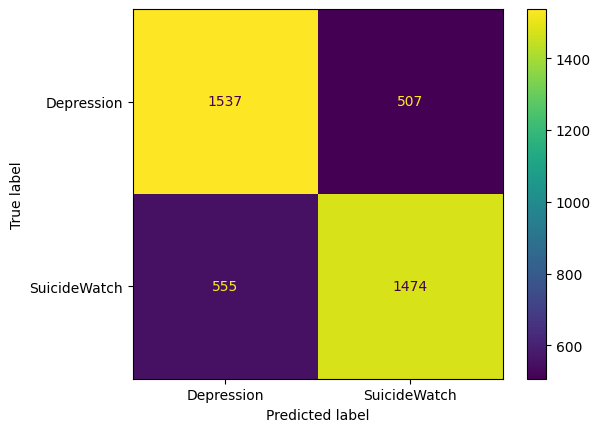

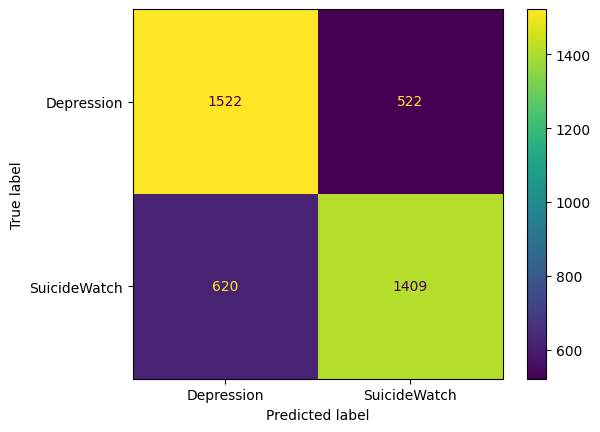

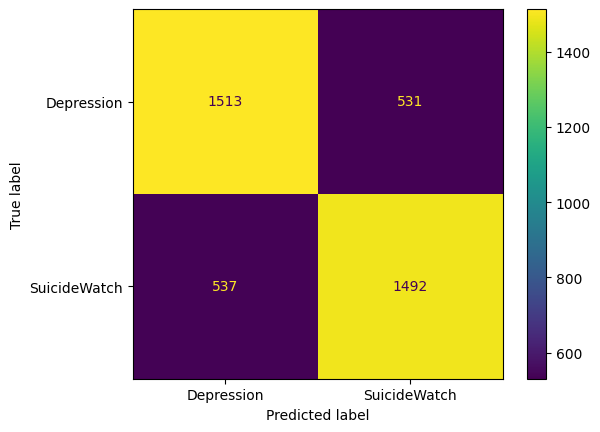

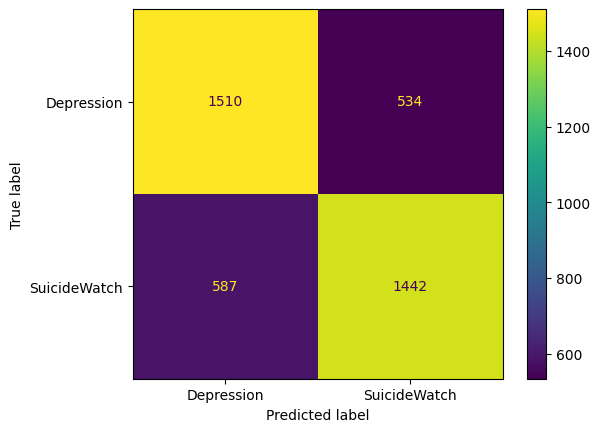

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Loop through models and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))

    # confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Depression", "SuicideWatch"])
    disp.plot()


what

In [ ]:
import re

def clean_test(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # remove extra whitespace
    return text

df['text_clean'] = df['text'].apply(clean_test)
df.iloc[10:20]

,text,label,text_clean
10,Been stuck in a loop of ruminating/ overthinki...,depression,been stuck in a loop of ruminating overthinkin...
11,Since I began seeing a therapist 5 months ago ...,depression,since i began seeing a therapist 5 months ago ...
12,Did your depression start after a time of seri...,depression,did your depression start after a time of seri...
13,I am on zoloft and focalin and it is changed m...,SuicideWatch,i am on zoloft and focalin and it is changed m...
14,I am going to make this short because i hate t...,depression,i am going to make this short because i hate t...
15,"I have really bad feelings, but always when I ...",SuicideWatch,i have really bad feelings but always when i t...
16,Everyone in my schooling system thinks I am au...,SuicideWatch,everyone in my schooling system thinks i am au...
17,I have been talking to someone who I really li...,depression,i have been talking to someone who i really li...
18,"I have so many stressors in my life, all major...",SuicideWatch,i have so many stressors in my life all major ...
19,Imagine waking up only hanging on by a thread ...,SuicideWatch,imagine waking up only hanging on by a thread ...


In [ ]:
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=32d7c5d60f43f62de1f75e5b7e25e5c8a6c9d0d1fe6cac71ebf51efe4fdfad2d
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex


In [ ]:
from nrclex import NRCLex

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def extract_nrc_features(text):
    emotion = NRCLex(str(text))
    scores = emotion.raw_emotion_scores
    emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'positive', 'negative']
    return {e: scores.get(e, 0) for e in emotions}

nrc_features = df['text_clean'].apply(extract_nrc_features)
nrc_df = pd.json_normalize(nrc_features)


In [ ]:
from sklearn.model_selection import train_test_split

X = nrc_df
y = df['label']  # 0 = Depression, 1 = Suicide

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.57      2074
           1       0.55      0.52      0.53      1999

    accuracy                           0.55      4073
   macro avg       0.55      0.55      0.55      4073
weighted avg       0.55      0.55      0.55      4073

Confusion Matrix:
 [[1218  856]
 [ 967 1032]]


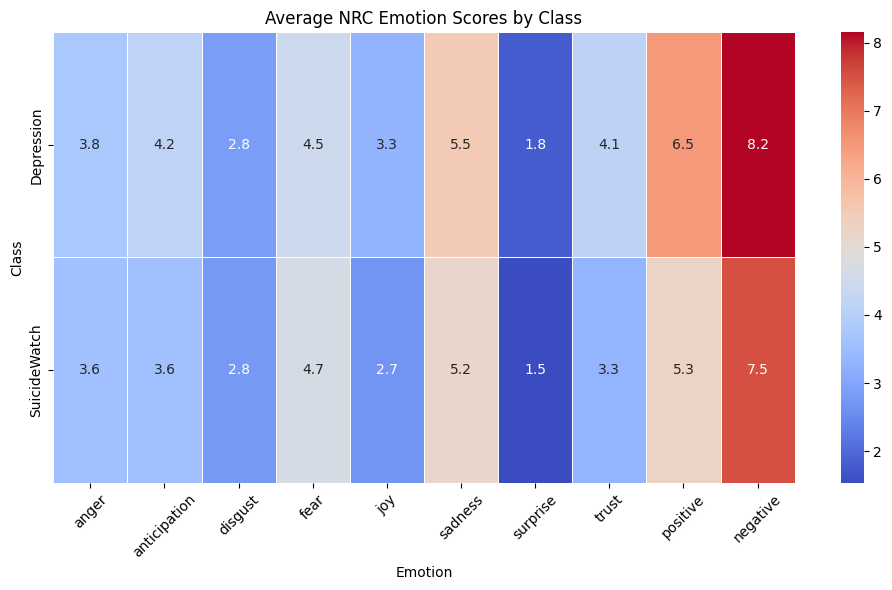

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Add label to the DataFrame
nrc_df['label'] = y.values

# Step 2: Group by label and compute mean
emotion_means = nrc_df.groupby('label').mean()
emotion_means.index = ['Depression', 'SuicideWatch']

# Step 3: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(emotion_means, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Average NRC Emotion Scores by Class")
plt.ylabel("Class")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
pip install contractions

In [ ]:
import contractions

def expand_contractions(text):
    return contractions.fix(text)

def clean_and_expand(text):
    text = str(text).lower()
    text = contractions.fix(text)  # expands can't → can not
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text_clean'] = df['text'].apply(clean_and_expand)
df.iloc[10:20]

,text,label,text_clean
10,Been stuck in a loop of ruminating/ overthinki...,depression,been stuck in a loop of ruminating overthinkin...
11,Since I began seeing a therapist 5 months ago ...,depression,since i began seeing a therapist 5 months ago ...
12,Did your depression start after a time of seri...,depression,did your depression start after a time of seri...
13,I am on zoloft and focalin and it is changed m...,SuicideWatch,i am on zoloft and focalin and it is changed m...
14,I am going to make this short because i hate t...,depression,i am going to make this short because i hate t...
15,"I have really bad feelings, but always when I ...",SuicideWatch,i have really bad feelings but always when i t...
16,Everyone in my schooling system thinks I am au...,SuicideWatch,everyone in my schooling system thinks i am au...
17,I have been talking to someone who I really li...,depression,i have been talking to someone who i really li...
18,"I have so many stressors in my life, all major...",SuicideWatch,i have so many stressors in my life all major ...
19,Imagine waking up only hanging on by a thread ...,SuicideWatch,imagine waking up only hanging on by a thread ...


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

nlp.max_length = 26129908

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])
df['text_lemma'] = df['text_clean'].apply(lemmatize_text)
df.iloc[10:20]

,text,label,text_clean,text_lemma
10,Been stuck in a loop of ruminating/ overthinki...,depression,been stuck in a loop of ruminating overthinkin...,be stick in a loop of ruminating overthinke I ...
11,Since I began seeing a therapist 5 months ago ...,depression,since i began seeing a therapist 5 months ago ...,since I begin see a therapist 5 month ago I ha...
12,Did your depression start after a time of seri...,depression,did your depression start after a time of seri...,do your depression start after a time of serio...
13,I am on zoloft and focalin and it is changed m...,SuicideWatch,i am on zoloft and focalin and it is changed m...,I be on zoloft and focalin and it be change my...
14,I am going to make this short because i hate t...,depression,i am going to make this short because i hate t...,I be go to make this short because I hate thin...
15,"I have really bad feelings, but always when I ...",SuicideWatch,i have really bad feelings but always when i t...,I have really bad feeling but always when I tr...
16,Everyone in my schooling system thinks I am au...,SuicideWatch,everyone in my schooling system thinks i am au...,everyone in my schooling system think I be aut...
17,I have been talking to someone who I really li...,depression,i have been talking to someone who i really li...,I have be talk to someone who I really like th...
18,"I have so many stressors in my life, all major...",SuicideWatch,i have so many stressors in my life all major ...,I have so many stressor in my life all major t...
19,Imagine waking up only hanging on by a thread ...,SuicideWatch,imagine waking up only hanging on by a thread ...,imagine wake up only hang on by a thread and t...


In [ ]:
from collections import Counter
import spacy

nlp = spacy.load("en_core_web_sm")

# Initialize verb counter
verb_counter = Counter()

# Loop through each post and count verbs
for text in df['text_lemma']:
    doc = nlp(str(text))
    verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    verb_counter.update(verbs)

# Get top 30 verbs
top_verbs = verb_counter.most_common(30)

# Convert to DataFrame
import pandas as pd
verb_df = pd.DataFrame(top_verbs, columns=["Verb", "Frequency"])
verb_df.head(30)


,Verb,Frequency
0,be,65086
1,have,33028
2,feel,27516
3,want,23401
4,get,20686
5,go,18545
6,do,18453
7,know,17721
8,think,12787
9,make,11648


In [ ]:
verb_df.head(31)

,Verb,Frequency
0,be,65086
1,have,33028
2,feel,27516
3,want,23401
4,get,20686
5,go,18545
6,do,18453
7,know,17721
8,think,12787
9,make,11648


In [ ]:
def extract_generalized_empathy_features(text):
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc if token.pos_ == "VERB"]

    # Define verb sets
    thinks_verbs = {'think', 'know', 'want', 'need', 'feel'}
    says_verbs = {'say', 'tell', 'talk'}
    does_verbs = {'try', 'go', 'leave', 'kill', 'die', 'keep', 'start', 'end', 'live', 'care'}

    # Check for presence
    features = {
        'thinks_verbs_used': int(any(v in lemmas for v in thinks_verbs)),
        'says_verbs_used': int(any(v in lemmas for v in says_verbs)),
        'does_verbs_used': int(any(v in lemmas for v in does_verbs))
    }

    return features
empathy_features = df['text_lemma'].apply(extract_generalized_empathy_features)
empathy_df = pd.json_normalize(empathy_features)


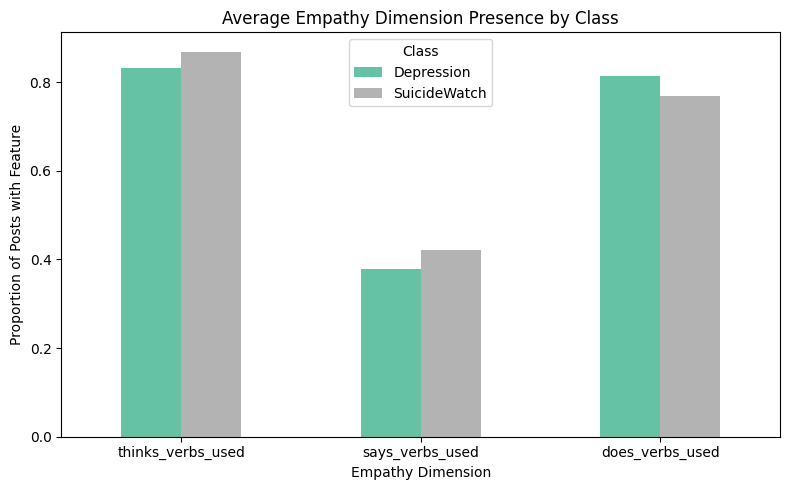

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add labels back to empathy_df
empathy_df['label'] = df['label'].values

# Group by class and get means
mean_empathy = empathy_df.groupby('label').mean()
mean_empathy.index = ['Depression', 'SuicideWatch']

# Plot as barplot
mean_empathy.T.plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Average Empathy Dimension Presence by Class")
plt.ylabel("Proportion of Posts with Feature")
plt.xlabel("Empathy Dimension")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.tight_layout()
plt.show()
